# Mini-batch Stochastic Gradient Descent

In each iteration, the gradient descent uses the entire training data set to compute the gradient, so it is sometimes referred to as batch gradient descent. Stochastic gradient descent (SGD) only randomly select one example in each iteration to compute the gradient. Just like in the previous chapters, we can perform random uniform sampling for each iteration to form a mini-batch and then use this mini-batch to compute the gradient. Now, we are going to discuss mini-batch stochastic gradient descent.

Set objective function $f(\boldsymbol{x}): \mathbb{R}^d \rightarrow \mathbb{R}$. The time step before the start of iteration is set to 0. The independent variable of this time step is $\boldsymbol{x}_0\in \mathbb{R}^d$ and is usually obtained by random initialization. In each subsequent time step $t>0$, mini-batch SGD uses random uniform sampling to get a mini-batch $\mathcal{B}_t$ made of example indices from the training data set. We can use sampling with replacement or sampling without replacement to get a mini-batch example. The former method allows duplicate examples in the same mini-batch, the latter does not and is more commonly used. We can use either of the two methods

$$\boldsymbol{g}t \leftarrow \nabla f{\mathcal{B}t}(\boldsymbol{x}{t-1}) = \frac{1}{|\mathcal{B}|} \sum_{i \in \mathcal{B}t}\nabla f_i(\boldsymbol{x}{t-1})$$

to compute the gradient $\boldsymbol{g}t$ of the objective function at $\boldsymbol{x}{t-1}$ with mini-batch $\mathcal{B}_t$ at time step $t$. Here, $|\mathcal{B}|$ is the size of the batch, which is the number of examples in the mini-batch. This is a hyper-parameter. Just like the stochastic gradient, the mini-batch SGD $\boldsymbol{g}t$ obtained by sampling with replacement is also the unbiased estimate of the gradient $\nabla f(\boldsymbol{x}{t-1})$. Given the learning rate $\eta_t$ (positive), the iteration of the mini-batch SGD on the independent variable is as follows:

$$\boldsymbol{x}t \leftarrow \boldsymbol{x}{t-1} - \eta_t \boldsymbol{g}_t.$$

The variance of the gradient based on random sampling cannot be reduced during the iterative process, so in practice, the learning rate of the (mini-batch) SGD can self-decay during the iteration, such as $\eta_t=\eta t^\alpha$ (usually $\alpha=-1$ or $-0.5$), $\eta_t = \eta \alpha^t$ (e.g $\alpha=0.95$), or learning rate decay once per iteration or after several iterations. As a result, the variance of the learning rate and the (mini-batch) SGD will decrease. Gradient descent always uses the true gradient of the objective function during the iteration, without the need to self-decay the learning rate.

The cost for computing each iteration is $\mathcal{O}(|\mathcal{B}|)$. When the batch size is 1, the algorithm is an SGD; when the batch size equals the example size of the training data, the algorithm is a gradient descent. When the batch size is small, fewer examples are used in each iteration, which will result in parallel processing and reduce the RAM usage efficiency. This makes it more time consuming to compute examples of the same size than using larger batches. When the batch size increases, each mini-batch gradient may contain more redundant information. To get a better solution, we need to compute more examples for a larger batch size, such as increasing the number of epochs.

## Reading Data

In this chapter, we will use a data set developed by NASA to test the wing noise from different aircraft to compare these optimization algorithms. We will use the first 1500 examples of the data set, 5 features, and a normalization method to preprocess the data.

In [1]:
import sys
sys.path.insert(0, '..')
%matplotlib inline
import d2l
import torch
import torch.nn as nn
import numpy as np
import time

In [2]:
def get_data():
    data = np.genfromtxt('../data/airfoil_self_noise.dat', delimiter='\t')
    data = (data - data.mean(axis=0)) / data.std(axis=0)
    return torch.Tensor(data[:1500, :-1]), torch.Tensor(data[:1500, -1])

features, labels =get_data()
features.shape

torch.Size([1500, 5])

## Implementation from Scratch

We have already implemented the mini-batch SGD algorithm in the chapter linear cratch. We have made its input parameters more generic here, so that we can conveniently use the same input for the other optimization algorithms introduced later in this chapter. Specifically, we add the status input states and place the hyper-parameter in dictionary hyperparams. In addition, we will average the loss of each mini-batch example in the training function, so the gradient in the optimization algorithm does not need to be divided by the batch size.

In [3]:
def sgd(params, states, hyperparams,batch_size):
    for p in params:
        p.data.sub_(hyperparams['lr'] * p.grad)
        p.grad.data.zero_()

Next, we are going to implement a generic training function to facilitate the use of the other optimization algorithms introduced later in this chapter. It initializes a linear regression model and can then be used to train the model with the mini-batch SGD and other algorithms introduced in subsequent sections.

In [4]:
def train(trainer_fn, states, hyperparams, features, labels,batch_size=10, num_epochs=2):
    
    # Initialize model parameters
    net, loss = d2l.linreg, d2l.squared_loss
    w = torch.ones(()).new_empty((features.shape[1], 1),requires_grad=True)
    w.requires_grad=True
    b= torch.zeros((1,),requires_grad=True)
    l= torch.zeros((1500,1),requires_grad=True)
    def eval_loss():
        return loss(net(features, w, b), labels).mean()
    ls, ts = [eval_loss()], [0,]
    data_iter = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(features, labels), batch_size, shuffle=True)
    start = time.time()
    for _ in range(num_epochs):
        for batch_i, (X, y) in enumerate(data_iter):
            l = loss(torch.mm(X,w)+b,y).mean()
            l.backward()
            trainer_fn([w, b], states, hyperparams,batch_size)
            if (batch_i + 1) * batch_size % 10 == 0:
                ts.append(time.time() - start + ts[-1])
                ls.append(eval_loss())
                start = time.time()
    print('loss: %f, %f sec per epoch' % (ls[-1], ts[-1]/num_epochs))
    d2l.set_figsize()
    d2l.plt.plot(np.linspace(0, num_epochs, len(ls)), ls)
    d2l.plt.xlabel('epoch')
    d2l.plt.ylabel('loss')
    return ts, ls  

When the batch size equals 1500 (the total number of examples), we use gradient descent for optimization. The model parameters will be iterated only once for each epoch of the gradient descent. As we can see, the downward trend of the value of the objective function (training loss) flattened out after 6 iterations.

loss: 307633045530214400.000000, 0.100617 sec per epoch


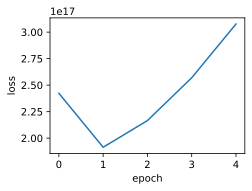

In [5]:
def train_sgd(lr, batch_size, num_epochs=2):
    return train(sgd, None, {'lr': lr}, features, labels, batch_size, num_epochs)
gd_res = train_sgd(1, 1500,4)


When the batch size equals 1, we use SGD for optimization. In order to simplify the implementation, we did not self-decay the learning rate. Instead, we simply used a small constant for the learning rate in the (mini-batch) SGD experiment. In SGD, the independent variable (model parameter) is updated whenever an example is processed. Thus it is updated 1500 times in one epoch. As we can see, the decline in the value of the objective function slows down after one epoch.

Although both the procedures processed 1500 examples within one epoch, SGD consumes more time than gradient descent in our experiment. This is because SGD performed more iterations on the independent variable within one epoch, and it is harder for single-example gradient computation to use parallel computing effectively.

loss: 116495395187527782498304.000000, 0.975641 sec per epoch


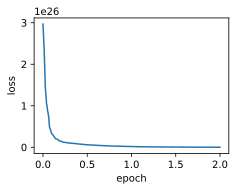

In [6]:
sgd_res = train_sgd(0.005, 1)

When the batch size equals 100, we use mini-batch SGD for optimization. The time required for one epoch is between the time needed for gradient descent and SGD to complete the same epoch.

loss: 3835346288640.000000, 0.050616 sec per epoch


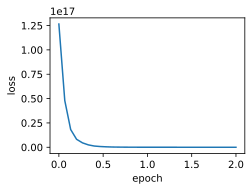

In [7]:
mini1_res = train_sgd(.4, 100)

Reduce the batch size to 10, the time for each epoch increases because the workload for each batch is less efficient to execute.

loss: 1376742932480.000000, 0.105193 sec per epoch


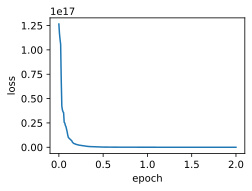

In [8]:
mini2_res = train_sgd(.05, 10)

Finally, we compare the time versus loss for the preview four experiments. As can be seen, despite SGD converges faster than GD in terms of number of examples processed, it uses more time to reach the same loss than GD because that computing gradient example by example is not efficient. Mini-batch SGD is able to trade-off the convergence speed and computation efficiency. Here, a batch size 10 improves SGD, and a batch size 100 even outperforms GD.

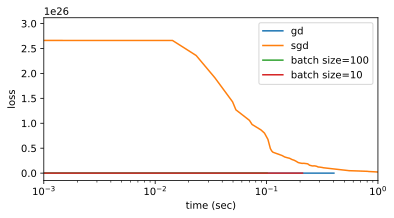

In [9]:
d2l.set_figsize([6, 3])
for res in [gd_res, sgd_res, mini1_res, mini2_res]:
    d2l.plt.plot(res[0], res[1])
    d2l.plt.xlabel('time (sec)')
    d2l.plt.ylabel('loss')
    d2l.plt.xscale('log')
    d2l.plt.xlim([1e-3, 1])
    d2l.plt.legend(['gd', 'sgd', 'batch size=100', 'batch size=10']);

## Summary
* Mini-batch stochastic gradient uses random uniform sampling to get a mini-batch training example for gradient computation.
* In practice, learning rates of the (mini-batch) SGD can self-decay during iteration.
* In general, the time consumption per epoch for mini-batch stochastic gradient is between what takes for gradient descent and SGD to complete the same epoch.

## Exercises
* Modify the batch size and learning rate and observe the rate of decline for the value of the objective function and the time consumed in each epoch.